# Multivariate Imputation with Scikit-Learn


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score


In [ ]:
# Generate a fake regression dataset

X, y = make_regression(n_samples=1000, n_features=3, random_state=30, effective_rank=2)
X = np.interp(X, (X.min(), X.max()), (0, 5000))
y = np.interp(y, (y.min(), y.max()), (100, 10000))


df = pd.DataFrame(X, columns=["col1", "col2", "col3"])
df["target"] = y
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    1000 non-null   float64
 1   col2    1000 non-null   float64
 2   col3    1000 non-null   float64
 3   target  1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


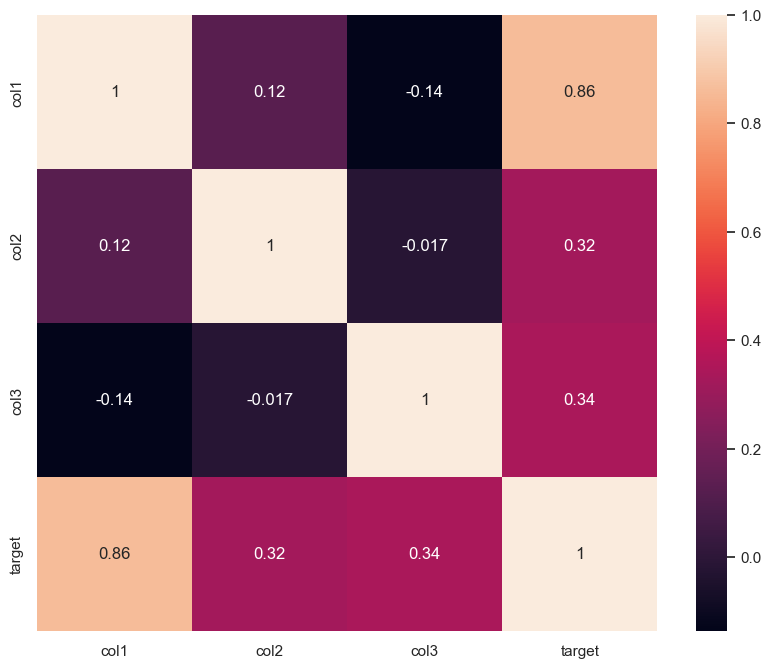

In [ ]:
# Plot heatmap

plot_df = df.copy()

plt.figure(figsize=(10, 8))
cmap = plot_df.corr()
sns.heatmap(cmap, annot=True)
plt.show()


In [ ]:
# Remove 40% of target column

length = len(df)
num = int(0.4*length)

df_missing = df.copy()

idx_replace = np.random.randint(0, length-1, num)
df_missing.iloc[idx_replace, 3] = np.NaN

df_missing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    1000 non-null   float64
 1   col2    1000 non-null   float64
 2   col3    1000 non-null   float64
 3   target  671 non-null    float64
dtypes: float64(4)
memory usage: 31.4 KB


## Iterative Imputation


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(random_state=0)

iterative_df = pd.DataFrame(imp.fit_transform(df_missing), columns=df_missing.columns)



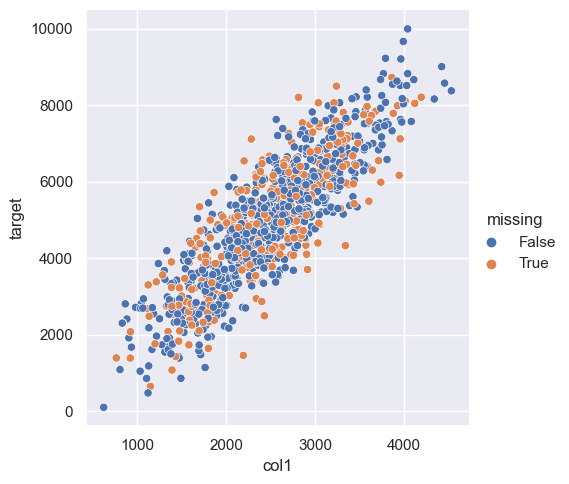

In [ ]:
plot_df = iterative_df.copy()
plot_df["missing"] = df_missing["target"].isna()
sns.relplot(x="col1", y="target", hue="missing", kind="scatter", data=plot_df)


## KNN Imputation


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
knn_df = pd.DataFrame(scaler.fit_transform(df_missing), columns=df_missing.columns)


In [ ]:
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=10)
knn_df = pd.DataFrame(imp.fit_transform(knn_df), columns=knn_df.columns)

knn_df = pd.DataFrame(scaler.inverse_transform(knn_df), columns=knn_df.columns)
knn_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    1000 non-null   float64
 1   col2    1000 non-null   float64
 2   col3    1000 non-null   float64
 3   target  1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


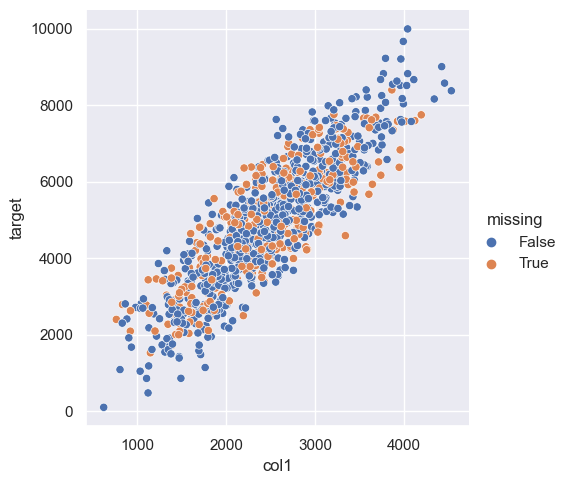

In [ ]:
plot_df = knn_df.copy()
plot_df["missing"] = df_missing["target"].isna()
sns.relplot(x="col1", y="target", hue="missing", kind="scatter", data=plot_df)


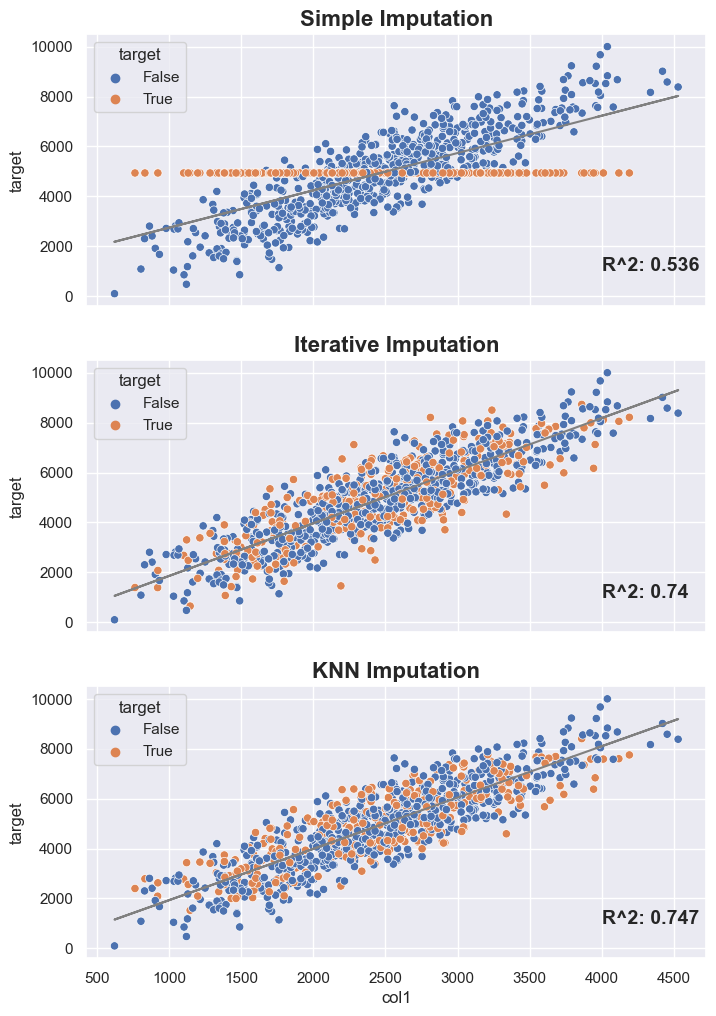

In [ ]:
from sklearn.impute import SimpleImputer

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8, 12))
axes = np.reshape(axes, -1)

# Use SimpleImputer as a baseline of comparison
simple_df = df_missing.copy()
imp_mean = SimpleImputer(strategy='mean')
simple_df = pd.DataFrame(imp_mean.fit_transform(simple_df), columns=simple_df.columns)

# Plot each imputation method
dfs = [simple_df, iterative_df, knn_df]
titles = ["Simple Imputation", "Iterative Imputation", "KNN Imputation"]

for i, df in enumerate(dfs):
    axes[i].set_title(titles[i], fontsize=16, fontweight='bold')

    missing = df_missing["target"].isna()
    sns.scatterplot(ax=axes[i], data=df, x="col1", y="target", hue=missing)
    
    # Plot line of best fit
    x = df["col1"]
    y = df["target"]
    m, b = np.polyfit(x, y, 1)
    linreg = m*x + b
    axes[i].plot(x, linreg, color='grey')
    
    # Calculate r squared value
    r2 = round(r2_score(y, linreg), 3)
    axes[i].text(4000, 1000, f'R^2: {r2}', fontsize=14, fontweight='bold')
